<a href="https://colab.research.google.com/github/GwiHwan-Go/Detect_SC/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 수집한 데이터를 분석해 봅시다.

##### 본 스크립트의 코드들은 3-4분 정도의 연산 시간을 필요로 합니다.

참고 자료 : [딥러닝을 이용한 자연어 처리 입문](!https://wikidocs.net/92961), [SoyNLP 공식 문서](!https://github.com/lovit/soynlp)

In [1]:
!pip install soynlp
!pip install konlpy
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 제공하는 데이터 설명

1. 데이터 설명 : DCinside 라는 커뮤니티에서 우울증 갤러리라는 곳의 게시물들의 '제목'들.
2. 데이터 오버뷰

  - 데이터 크기 : 2,470,236 개

  - 데이터 피쳐 : title (텍스트 데이터), author (작성자 id), date (작성 날짜)
  
3. 텍스트 데이터 : 미리 학습시킨 토크나이저로 토큰화한 데이터로 ' '로 구분되어 있음.




In [2]:
# 데이터 다운로드, 파일명은 sns_data.csv 
file_name = 'sns_data.csv'
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-4qx3IRyXUtb_QSItiWyIHZIo9hcBttg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-4qx3IRyXUtb_QSItiWyIHZIo9hcBttg" -O $file_name && rm -rf ~/cookies.txt


--2022-10-31 01:27:53--  https://docs.google.com/uc?export=download&confirm=t&id=1-4qx3IRyXUtb_QSItiWyIHZIo9hcBttg
Resolving docs.google.com (docs.google.com)... 142.251.16.113, 142.251.16.100, 142.251.16.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9rse2d5su4ck2nac8dlklh1skjvvcs6e/1667179650000/15740322463873228959/*/1-4qx3IRyXUtb_QSItiWyIHZIo9hcBttg?e=download&uuid=f8b42cac-a639-40d5-81e6-2145c3390374 [following]
--2022-10-31 01:27:53--  https://doc-0o-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9rse2d5su4ck2nac8dlklh1skjvvcs6e/1667179650000/15740322463873228959/*/1-4qx3IRyXUtb_QSItiWyIHZIo9hcBttg?e=download&uuid=f8b42cac-a639-40d5-81e6-2145c3390374
Resolving doc-0o-30-docs.googleusercontent.com (doc-0o-30-docs.googleusercontent.com)... 142.251.163.132,

In [3]:
# 데이터 살펴보기
data = pd.read_csv(file_name, low_memory=False, index_col=0) 
first_date, last_date = data.loc[0,'date'], data.loc[data.shape[0]-1,'date']
print("수집한 게시물 범위 :", first_date, "~", last_date, "\n" \
      "수집된 데이터 크기 :", data.shape[0], "\n수집한 데이터 features :", data.columns)
data.tail()

수집한 게시물 범위 : 2021-03-03 ~ 2022-10-27 
수집된 데이터 크기 : 2470236 
수집한 데이터 features : Index(['title', 'author', 'date'], dtype='object')


,title,author,date
2470231,나 병신 ...,16125,2022-10-27
2470232,나고 닉 글 올리 규 싶 읃데,12779,2022-10-27
2470233,씨발 남자 직원 음식 깔아 주,5291,2022-10-27
2470234,나도 근데 아이디 두 번 바꿈,15378,2022-10-27
2470235,알바 바보 쉨 ㅋㅋㅋ 나도 차단 해봐라,16125,2022-10-27


In [4]:
## 혹시 모를, nan 값을 제거해주자.
print(f"NAN 제거 전 데이터 수 = {data.shape}")
data = data[data.title.isna()==False]
data = data.reset_index(drop=True)
print(f"NAN 제거 후 데이터 수 = {data.shape}")

NAN 제거 전 데이터 수 = (2470236, 3)
NAN 제거 후 데이터 수 = (2469803, 3)


### 커스텀 토크나이저 만들기 w/ SoyNLP

기존의 토크나이저(konlpy, hanspell 등)들은 대부분 뉴스, 위키백과 등을 학습하여 만들어졌다. 

하지만, 우리가 오늘 다룰 데이터는 SNS 데이터로 각종 **신조어, 비표준어**가 난무한다.

기존의 토크나이저는 이와 같은 데이터를 잘 다루지 못하기 때문에,

[SoyNLP](!https://github.com/lovit/soynlp#tokenizer) 에서 제시한 비지도 학습 기반 토크나이저를 채택하였다.

이 토크나이저는 동질의 문서의 구조를 학습해서 글자 간의 __응집력__을 통해서 단어를 구분하는 알고리즘으로 설계되었다. 

자세한 부분은 [공식 문서](!https://github.com/lovit/soynlp#tokenizer)를 참고 해보자.

SoyNLP Tokenizer는 학습시키는데, 30분 정도 걸리기 때문에,

여기서는 미리 학습시킨 Tokenizer 모델을 제공한다.

직접 학습시키고 싶다면, 아래 코드를 돌려보자. 

더 자세한 내용은 [여기](!https://github.com/lovit/soynlp#tokenizer)에서 확인할 수 있다.

```python
    from soynlp.word import WordExtractor
    word_extractor = WordExtractor()
    word_extractor.train(data[data.title.isna()==False].title)
    word_score_table = word_extractor.extract()
```

In [5]:
extractor_name = 'soy_wordExtractor.model'
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-RrET_of1A3NVWWYnr3PMR-apTZ9dB7J' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-RrET_of1A3NVWWYnr3PMR-apTZ9dB7J" -O $extractor_name && rm -rf ~/cookies.txt


--2022-10-31 01:28:10--  https://docs.google.com/uc?export=download&confirm=&id=1-RrET_of1A3NVWWYnr3PMR-apTZ9dB7J
Resolving docs.google.com (docs.google.com)... 142.251.16.113, 142.251.16.100, 142.251.16.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c50mcrsqo5vg2s069rrame54qqsd3sdp/1667179650000/15740322463873228959/*/1-RrET_of1A3NVWWYnr3PMR-apTZ9dB7J?e=download&uuid=04d45609-73b5-4d7c-b658-15bed70c907a [following]
--2022-10-31 01:28:13--  https://doc-0o-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c50mcrsqo5vg2s069rrame54qqsd3sdp/1667179650000/15740322463873228959/*/1-RrET_of1A3NVWWYnr3PMR-apTZ9dB7J?e=download&uuid=04d45609-73b5-4d7c-b658-15bed70c907a
Resolving doc-0o-30-docs.googleusercontent.com (doc-0o-30-docs.googleusercontent.com)... 142.251.163.132, 

In [6]:
import math
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

## Word_Extractor param 설정 및 로드
word_extractor = WordExtractor(min_frequency=10,
                               min_cohesion_forward=5.0,
                               min_right_branching_entropy=0.0)
word_extractor.load(extractor_name)

## Cohesion 과 Entropy 계산해서 tokenizer 에 필요한 scores 계산
scores = word_extractor.word_scores()
scores = {key : (scores[key].cohesion_forward * math.exp(scores[key].right_branching_entropy)) \
          for key in scores.keys()}

## tokenizer 생성
tokenizer = LTokenizer(scores=scores)

all cohesion probabilities was computed. # words = 480337
all branching entropies was computed # words = 523918
all accessor variety was computed # words = 523918


### 커스텀 토크나이저

본 분석에서 이용한 커스텀 토크나이저를 소개한다.

SoyNLP 토크나이저는 품사 태깅을 하지 못해서 Okt 모듈로 품사 태깅을 한 후에

조사를 제외해주었다.

In [7]:
## SoyNLP 사용 예 -> SoyNLP(tokenizer) -> okt pos tagger -> 불용어 제거
from konlpy.tag import Okt
from soynlp.normalizer import *

def preprocess_tokenizer(sentence) : 

  pos_tagger = Okt()

  return [word[0]
          for word in pos_tagger.pos(' '.join(tokenizer.tokenize(sentence)))
          if word[1] != 'Josa'] # 조사는 분석에서 제외


In [8]:
## 문장을 넣어서 토크나이저의 성능을 체크해보자.
play_sentences= "야이개색야"
preprocess_tokenizer(play_sentences)

['야', '이', '개색']

## PMI 분석

출처 : [SoyNLP 공식문서](!https://github.com/lovit/soynlp/blob/master/tutorials/pmi_usage.ipynb)

이제 마지막 단계이다.

단어들 간의 연관관계를 분석해서 자살 관련 정보 파악에 도움이 되는 __다른 단어__들은 무엇이 있는 지 알아보자.

PMI 분석은

(word, contexts) 혹은 (input, outputs)의 상관성을 측정하는 방법으로, pmi 값이 클수록 두 변수의 상관성이 크다.

이를 위해서 특정 단어와 그 주위 단어들을 저장하는 행렬인 Word-Contexts Matrix를 생성한다.

아래 코드는 정제된 데이터를 통해서

word_contexts matrix를 가지고 있는 pmi 인스턴스를 생성한다.(인스턴스 생성은 3분정도 걸림)

생성된 pmi 인스턴스를 통해 수집한 데이터 속 단어들의 문맥과 유사 단어들을 알 수 있다.



In [10]:
from soynlp.word import pmi as pmi_func
from sklearn.metrics import pairwise_distances
from soynlp.vectorizer import sent_to_word_contexts_matrix
import numpy as np

class Pmi() :

  def __init__(self, text_data) :

    self.mat, self.idx2vocab = sent_to_word_contexts_matrix(
        text_data,
        windows=3,
        min_tf=10,
        tokenizer= lambda x:x.split(), # (default) lambda x:x.split(),
        dynamic_weight=False,
        verbose=True
    )

    self.pmi, self.px, self.py = pmi_func(
        self.mat,
        min_pmi = 0,
        alpha = 0.0,
        beta = 0.75
    )

    self.vocab2idx = {vocab:idx for idx, vocab in enumerate(self.idx2vocab)}

  def context_words(self ,target, topk=10) :
    """
    :target: str
        String type query word
    :param topk: int
        Maximum number of similar items.
        If set top as negative value, it returns similarity with all words
    Returns
    ----------
    similars : list of tuple
        List contains tuples (item, cosine similarity)
        Its length is topk
    """
    query = self.vocab2idx[target]

    submatrix = self.pmi[query, :].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:topk]
    most_relateds = [[idx, pmi_ij] for idx, pmi_ij in most_relateds]

    most_relateds = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    return most_relateds

  def similar_words(self, target, topk=10):
      """
      :target: str
          String type query word
      :param topk: int
          Maximum number of similar items.
          If set top as negative value, it returns similarity with all words
      Returns
      ----------
      similars : list of tuple
          List contains tuples (item, cosine similarity)
          Its length is topk
      """

      q = self.vocab2idx.get(target, -1)
      if q == -1:
          return []

      qvec = self.pmi[q].reshape(1,-1)
      dist = pairwise_distances(qvec, self.pmi, metric='cosine')[0]
      sim_idxs = dist.argsort()

      if topk > 0:
          sim_idxs = sim_idxs[:topk+1]

      results = [[idx, 1 - dist[idx]] for idx in sim_idxs if idx != q]
      # results = np.array(results)
      results = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in results]

      return results

  def np_context_words(self ,target, topk=10) :
    """
    효율적인 그래프 생성을 위한 코드.
    input(str) : a word
    ----------
    results : array of tuple
        List contains tuples (item, similarity)
        Its length is topk
    """
 
    submatrix = self.pmi[target, :].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:topk]
    most_relateds = [[idx, pmi_ij] for idx, pmi_ij in most_relateds]
    results = np.array(most_relateds)
    # most_relateds = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    return results

  def np_similar_words(self, target, topk=10):
      """
      효율적인 그래프 생성을 위한 코드.
      input(str) : a word
      ----------
      results : array of tuple
          List contains tuples (item, cosine similarity)
          Its length is topk
      """

      qvec = self.pmi[target].reshape(1,-1)
      dist = pairwise_distances(qvec, self.pmi, metric='cosine')[0]
      sim_idxs = dist.argsort()

      if topk > 0:
          sim_idxs = sim_idxs[:topk+1]

      results = [[idx, 1 - dist[idx]] for idx in sim_idxs if idx != q]
      results = np.array(results)

      return results
  
  def idx_to_word(self, indices_list) :
    
    return [self.idx2vocab[index] for index in indices_list]

  def word_to_idx(self, word_list) :

    return [self.vocab2idx[word] for word in word_list]

pmi = Pmi(data.title)

Create (word, contexts) matrix
  - counting word frequency from 2469802 sents, mem=2.855 Gb
  - scanning (word, context) pairs from 2469802 sents, mem=3.590 Gb
  - (word, context) matrix was constructed. shape = (49771, 49771)                    
  - done


### 결과

이제 우울증 갤러리에서 주로 얘기되는 단어들 간의 연결관계를 알 수 있다.

- Context Words : 비슷한 문맥을 가지는 단어.

- Similar Words : 문맥이 비슷한 단어.

target 변수에 알고싶은 단어를 넣어서 더 자세히 알아보자.

In [11]:
## 특정 단어['살고 싶다']와 함께 등장한 단어들 상위 10개##
target = '자살'
howmany = 10


pmi.context_words(target, howmany)

[('도피', 6.844622458591964),
 ('삵', 6.031369397834147),
 ('살고싶은데', 5.772712722570554),
 ('뽁뽁', 5.685233690813876),
 ('했데', 5.524714801301454),
 ('좆피', 5.288600593862374),
 ('자살', 5.274353861018971),
 ('머애', 5.262282104003921),
 ('은부', 5.249461278984446),
 ('대왕고래', 5.23685594024716)]

In [12]:
## 특정 단어['우울']과 컨텍스트가 가장 비슷한 단어 상위 10개##
target = '우울'
howmany = 10

pmi.similar_words(target, howmany)

[('심심', 0.22781712789543906),
 ('불안', 0.20654552217405342),
 ('우울함', 0.16989673506620928),
 ('행복', 0.16271023927659367),
 ('우울증', 0.1625480654125695),
 ('피곤', 0.15479783161764749),
 ('우울해', 0.14304488688384542),
 ('우울하다', 0.13556653025904541),
 ('불행', 0.13496097718192268),
 ('우울한', 0.13324270584997489)]

# 텍스트 분석 끝!


## 이젠 데이터를 시각화 해봅시다(수정중)

matplotlib은 한글을 기본으로 지원하지 않습니다.

먼저, 한글 폰트를 다운로드 받아줍니다.

그 후 아래 코드를 돌리면 결과값으로



In [66]:
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()
print([f for f in sys_font if 'Nanum' in f])

['/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumBrush.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf', '/usr/share/fonts

```
['/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf', '/usr/share/fonts/truetype/nanum/NanumBrush.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumPen.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundEB.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf']

```

가 프린트될 것입니다.
이 중 아무거나 선택해서 font_path 변수에 넣어주세요.

In [14]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf' 

### 먼저 데이터 전체를 살펴봅시다.

In [31]:
## 분석을 위한 '단어 수' 열 추가
data['len'] = data['title'].str.len()
## 달, 요일 분석을 위해 datetime object 로 변경
data.date = pd.to_datetime(data.date)

#### 게시물들은 주로 언제, 얼마나 작성되었을까?

In [32]:
df_month, df_day_name = data.copy(), data.copy()
df_month.date = data.date.dt.month
df_day_name.date = data.date.dt.day_name()

**월** 별로 데이터를 보자.

num_of_poasts는 한 달의 총 게시글 수이고,

len_of_posts는 한 달 안의 게시글의 총 글자 수이고,

authors는 한 달에 활동한 작성자 수이다.

In [69]:
result_by_month = pd.DataFrame({
    'num_of_post' : df_month.groupby(by='date').count().title,
    'len_of_posts' : df_month.groupby(by='date').sum().len,
    'authors' : df_month.groupby(['date', 'author']).count().groupby('date').count().len
    })
result_by_month.loc['sum',:]=result_by_month.sum()
result_by_month = result_by_month.reset_index().rename(columns={'date': 'month'}).set_index('month')
result_by_month = result_by_month.astype('int32')
result_by_month.head()

,num_of_post,len_of_posts,authors
month,,,
1,134720,2375398,3030
2,120460,2066365,3159
3,233532,3993865,5400
4,261214,4477571,5773
5,248482,4175985,5552


pandas 의 describe()를 이용해서 대략적인 통계수치를 볼 수 있다.

In [75]:
result_by_month.iloc[:-1,:].describe().astype('int32')

,num_of_post,len_of_posts,authors
count,12,12,12
mean,205816,3474327,4733
std,59589,983980,1315
min,120460,2066365,2708
25%,132878,2324070,3126
50%,234262,3937401,5414
75%,249761,4207368,5689
max,261214,4477571,5973


이젠 **`요일`** 별로 데이터를 보자.

num_of_poasts는 한 달의 총 게시글 수이고,

len_of_posts는 한 달 안의 게시글의 총 글자 수이고,

authors는 한 달에 활동한 작성자 수이다.

In [70]:
result_by_day_name = pd.DataFrame({
    'num_of_post' : df_day_name.groupby(by='date').count().title,
    'len_of_posts' : df_day_name.groupby(by='date').sum().len,
    'authors' : df_day_name.groupby(['date', 'author']).count().groupby('date').count().len
    })
result_by_day_name.loc['sum',:]=result_by_day_name.sum()
result_by_day_name = result_by_day_name.reset_index().rename(columns={'date': 'month'}).set_index('month')
result_by_day_name = result_by_day_name.astype('int32')
result_by_day_name.head()

,num_of_post,len_of_posts,authors
month,,,
Friday,349478,5878740,9605
Monday,360735,6074877,9529
Saturday,338140,5688806,9299
Sunday,369627,6205465,9494
Thursday,343012,5788446,9459


In [76]:
result_by_day_name.iloc[:-1,:].describe().astype('int32')

,num_of_post,len_of_posts,authors
count,7,7,7
mean,352829,5955990,9528
std,11312,190118,149
min,338140,5688806,9299
25%,345265,5833593,9476
50%,349478,5916537,9519
75%,361014,6106970,9567
max,369627,6205465,9791


#### 게시물에서는 주로 어떤 이야기가 오갔을까?

In [77]:
df_post = data.copy()

게시글의 단어들을 Counter 모듈을 이용해서 세고, 더해보자.

In [98]:
from tqdm import tqdm
from collections import Counter

def high_freq_words(counter) :
  return ' '.join([word for word,count in counter.most_common(200)])

tqdm.pandas()

# Counter로 각 게시글의 단어 세기
temp = df_post.title.progress_apply(lambda x : Counter( i for i in x.split(' ') if len(i)>1 ))

# 각 게시글의 Counter object 더해버리기 ( 25분 정도 걸림 )
# 시간이 너무 많이 걸리니 일부만 해 보자.
all_words = temp[:10000].sum()

100%|██████████| 2469803/2469803 [00:15<00:00, 164476.99it/s]



단어 : 의 문맥 단어 워드 클라우드



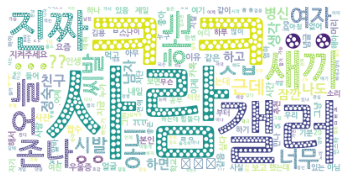

In [99]:
wc = WordCloud(font_path=font_path, relative_scaling=0.2,
               background_color='white').generate_from_frequencies(all_words)

plt.figure()
print(f"\n단어 : 의 문맥 단어 워드 클라우드\n")
plt.axis('off')
plt.imshow(wc)
plt.show()

#### 게시물들은 누가, 얼마나 작성했을까?

**작성자** 별로 데이터를 보자.

num_of_posts는 특정 작성자가 작성한 총 게시글 수이고,

len_of_posts는 특정 작성자가 작성한 게시글들의 길이의 합이며,

freq_word 특정 작성자가 사용하는 어휘의 빈도를 계산한 dictionary 이다.

In [100]:
df_author = data.copy()
df_author['word_count'] = df_author.title.progress_apply(lambda x : Counter( i for i in x.split(' ') if len(i)>1 ))


In [ ]:
## Counter 를 더하는 작업이 시간이 매우 오래 걸리는 작업입니다. 
## 더 효율적으로 못 짜서 죄송함다...

result_by_author = pd.DataFrame({
    'num_of_post' : df_author.loc[:,['author','title']].groupby('author').count(),
    'len_of_posts' : df_author.loc[:,['author','len']].groupby('author').sum(),
    'freq_word' : df_post.loc[:,['author','word_count']].groupby('author').sum().word_count
    })

## 특정 단어의 유사단어, 문맥 단어 그리기


단어 : 자살의 문맥 단어 워드 클라우드



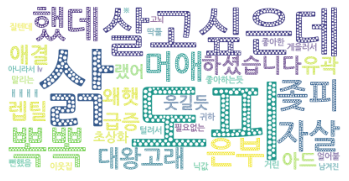


단어 : 자살의 유사 단어 워드 클라우드



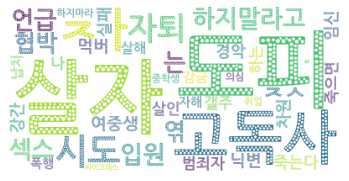


단어 : 동반의 문맥 단어 워드 클라우드



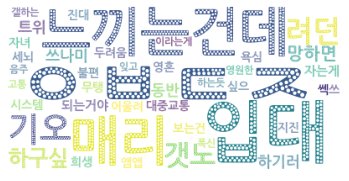


단어 : 동반의 유사 단어 워드 클라우드



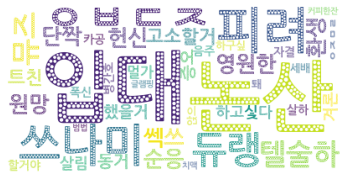


단어 : 죽을래의 문맥 단어 워드 클라우드



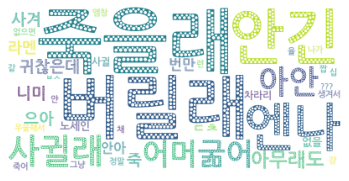


단어 : 죽을래의 유사 단어 워드 클라우드



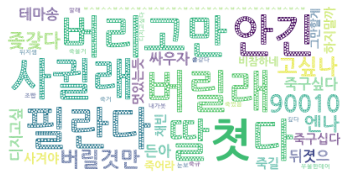


단어 : 투신의 문맥 단어 워드 클라우드



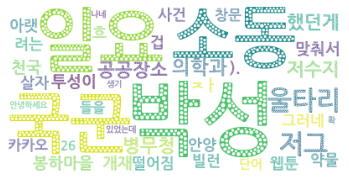


단어 : 투신의 유사 단어 워드 클라우드



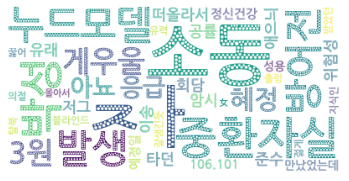


단어 : 자해의 문맥 단어 워드 클라우드



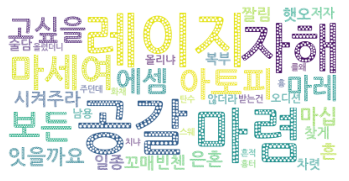


단어 : 자해의 유사 단어 워드 클라우드



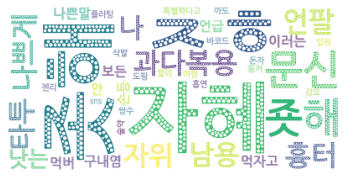


단어 : 죽고싶다의 문맥 단어 워드 클라우드



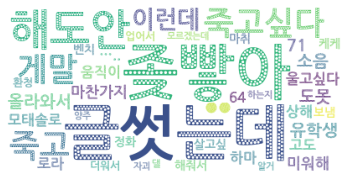


단어 : 죽고싶다의 유사 단어 워드 클라우드



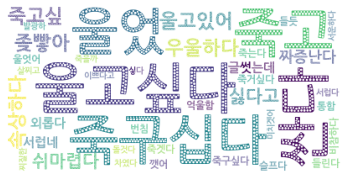


단어 : 우울의 문맥 단어 워드 클라우드



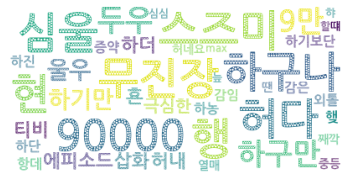


단어 : 우울의 유사 단어 워드 클라우드



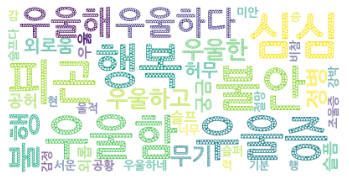


단어 : 살자의 문맥 단어 워드 클라우드



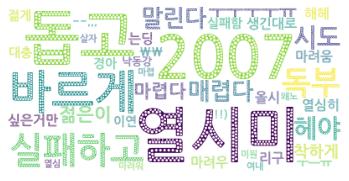


단어 : 살자의 유사 단어 워드 클라우드



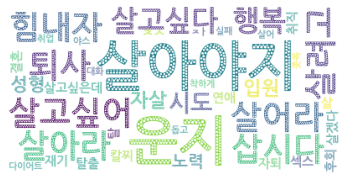


단어 : 인생의 문맥 단어 워드 클라우드



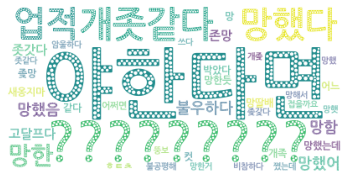


단어 : 인생의 유사 단어 워드 클라우드



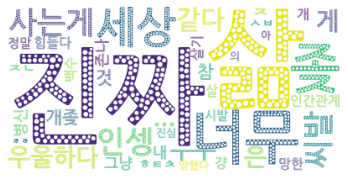


단어 : 죽음의 문맥 단어 워드 클라우드



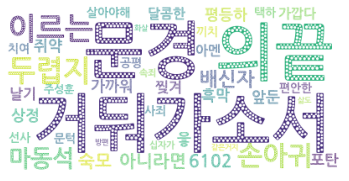


단어 : 죽음의 유사 단어 워드 클라우드



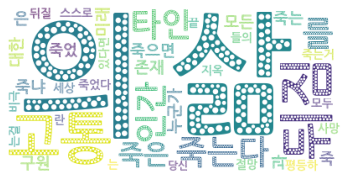

In [45]:
## SEED 단어들에 대해서 PMI 메트릭스를 통해
## 비슷한 단어들과 같은 맥락 단어들을 추출.
from wordcloud import WordCloud
import matplotlib.pyplot as plt

seeds= ['자살','동반','ㄷㅂㅈㅅ','ㅂㄱㅌ','자살계',
        '죽을래','투신','자살쇼','자살각','자해계','자해','자해전시','죽고싶다','우울','ㅈ해','살자',
        '인생','죽음']

for seed in seeds :
  if seed in pmi.vocab2idx :
      contexts = pmi.context_words(seed,topk=40)
      similars = pmi.similar_words(seed,topk=40)

      wc_context = WordCloud(font_path=font_path, relative_scaling=0.1,mode='RGB', prefer_horizontal=1.1,
                background_color='white',collocation_threshold=20).generate_from_frequencies(dict(contexts))
      wc_similar = WordCloud(font_path=font_path, relative_scaling=0.1,mode='RGB', prefer_horizontal=0.95,
                background_color='white',collocation_threshold=20).generate_from_frequencies(dict(similars))
     
      plt.figure()
      print(f"\n단어 : {seed}의 문맥 단어 워드 클라우드\n")
      plt.axis('off')
      plt.imshow(wc_context)
      plt.show()

      plt.figure()
      print(f"\n단어 : {seed}의 유사 단어 워드 클라우드\n")
      plt.axis('off')
      plt.imshow(wc_similar)
      plt.show()


# 텍스트 분석 끝!